Name: Hanish Sai Rohit
Ph no: 8332082623
email id: hanishsidhu@gmail.com
email id: hanishrohit@gmail.com

<h1 style="text-align:center;font-size:30px;" > Amazon Apparel Recommendations  </h1>

__ Problem Statement __

* To Recommend the similar products using Visual, Text, Brand and Color

In [54]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

# Data Cleaning & Data Analysis

In [2]:
# json file which consists of all information about the products
data = pd.read_json('tops_fashion.json')
print ('Number of data points : ', data.shape[0],
       '\nNumber of features/variables:', data.shape[1])

Number of data points :  183138 
Number of features/variables: 19


In [13]:
data.columns

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

Of these 19 features, we will be using only 6 features.
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

In [14]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [15]:
print ('Number of data points : ', data.shape[0], \
       '\nNumber of features:', data.shape[1])
data.head() 

Number of data points :  183138 
Number of features: 7


asin         brand              color  \
0  B016I2TS4W         FNC7C               None   
1  B01N49AI08  FIG Clothing               None   
2  B01JDPCOHO  FIG Clothing               None   
3  B01N19U5H5       Focal18               None   
4  B004GSI2OS   FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Womens Won Top            None  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...            None  
4  Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26

### Missing data for various features.

####  Basic stats for the feature: product_type_name

In [16]:
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


observation:
    * around 90% of the product_type_name values are SHIRT

In [18]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [19]:
# the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

####  Basic stats for the feature: brand

In [20]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [21]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

####  Basic stats for the feature: color

In [22]:
print(data['color'].describe())

# we have 7380 unique colors

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [23]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

####  Basic stats for the feature: formatted_price

In [24]:
 
print(data['formatted_price'].describe())

# Only 28,395 (15.5% of whole data) products with price information

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [25]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### Basic stats for the feature: title


In [26]:
print(data['title'].describe())

# All of the products have a title. 

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [28]:
data.to_pickle('180k_apparel_data')

In [29]:
# consider products which have price information
# data['formatted_price'].isnull() => gives the information 
#about the dataframe row's which have null values price == None|Null
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [30]:
# consider products which have color information
# data['color'].isnull() => gives the information about the dataframe row's which have null values price == None|Null
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


#### We brought down the number of data points from 183K  to 28K.

We are processing only 28K points cosidering the limitations of computation power. <br> 

In [31]:
data.to_pickle('28k_apparel_data')

### Removing near duplicate items

#### Understanding about duplicates.

In [33]:
# read data from pickle file from previous stage
data = pd.read_pickle('28k_apparel_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))
# we have 2325 products which have same title but different color


2325


#### These shirts are exactly same except in size (S, M,L,XL)

<table>
<tr> 
<td><img src="dedupe/B00AQ4GMCK.jpeg",width=100,height=100> :B00AQ4GMCK</td>
<td><img src="dedupe/B00AQ4GMTS.jpeg",width=100,height=100> :B00AQ4GMTS</td>
</tr>
<tr> 
<td><img src="dedupe/B00AQ4GMLQ.jpeg",width=100,height=100> :B00AQ4GMLQ</td>
<td><img src="dedupe/B00AQ4GN3I.jpeg",width=100,height=100> :B00AQ4GN3I</td>
</tr>
</table>

#### These shirts exactly same except  in color

<table>
<tr> 
<td><img src="dedupe/B00G278GZ6.jpeg",width=100,height=100> :B00G278GZ6</td>
<td><img src="dedupe/B00G278W6O.jpeg",width=100,height=100> :B00G278W6O</td>
</tr>
<tr> 
<td><img src="dedupe/B00G278Z2A.jpeg",width=100,height=100> :B00G278Z2A</td>
<td><img src="dedupe/B00G2786X8.jpeg",width=100,height=100> :B00G2786X8</td>
</tr>
</table>

#### In our data there are many duplicate products like the above examples, we need to de-dupe them for better results.


####  Remove duplicates : Part 1

In [34]:
data = pd.read_pickle('28k_apparel_data')

In [35]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
11  B001LOUGE4                 Fitness Etc.              Black   
15  B003BSRPB0                  FeatherLite              White   
21  B014ICEDNA                        FNC7C             Purple   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
11  https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
21  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26  
6   Women's Unique 100% Cotton T - Special Olympic...           $9.99  
11             Ladies Cotton Tank 2x1 Ribbed Tank Top          $11.99  
15  FeatherLite Ladies' Moisture Free Mesh Sport S...          $20.54  
21  Supernatural Chibis Sam Dean And Castiel Short...           $7.50

In [36]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [37]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

asin     brand        color  \
61973   B06Y1KZ2WB    Éclair   Black/Pink   
133820  B010RV33VE  xiaoming         Pink   
81461   B01DDSDLNS  xiaoming        White   
75995   B00X5LYO9Y  xiaoming  Red Anchors   
151570  B00WPJG35K  xiaoming        White   

                                         medium_image_url product_type_name  \
61973   https://images-na.ssl-images-amazon.com/images...             SHIRT   
133820  https://images-na.ssl-images-amazon.com/images...             SHIRT   
81461   https://images-na.ssl-images-amazon.com/images...             SHIRT   
75995   https://images-na.ssl-images-amazon.com/images...             SHIRT   
151570  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

#### Some examples of dupliacte titles that differ only in the last few words.

<pre>
Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
</pre>

In [38]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [39]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        
        if (length - count) > 2: # number of words in which both sensences differ
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [40]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

#### Removed  the dupliactes which differ only at the end.

In [41]:
print('Number of data points : ', data.shape[0])

Number of data points :  17593


In [43]:
data.to_pickle('17k_apperal_data')

#### Remove duplicates : Part 2

<pre>

In the previous cell, we sorted whole data in alphabetical order of  titles.Then, we removed titles which are adjacent and very similar title

But there are some products whose titles are not adjacent but very similar.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

</pre>

In [58]:
data = pd.read_pickle('17k_apperal_data')

In [55]:
import itertools

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []

while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3, we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 2:
            indices.remove(j)


In [56]:
# from whole previous products we will consider only 
# the products that are found in previous cell 
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [60]:
data.to_pickle('16k_apperal_data')
# Storing these products in a pickle file

#  Data pre-processing

In [61]:
data = pd.read_pickle('16k_apperal_data')

In [62]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

In [63]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

5.943001999999979 seconds


In [64]:
data.head(2)

asin                        brand              color  \
4  B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6  B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   

                                    medium_image_url product_type_name  \
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   
6  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
4  featherlite ladies long sleeve stain resistant...          $26.26  
6  womens unique 100 cotton  special olympics wor...           $9.99

In [65]:
data.to_pickle('16k_apperal_data_preprocessed')

# Weighted similarity using Text, Visual,Brand and Color.

__ Representation types __

* Title's text is represented using __IDF weighted Word to vector__.

* Image vectors are represented using Convolutional neural network.

* Brand and Color are represented using One Hot Encoding.

In [2]:
data = pd.read_pickle('16k_apperal_data_preprocessed')
data.head(2)

asin                        brand              color  \
4  B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6  B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   

                                    medium_image_url product_type_name  \
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   
6  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
4  featherlite ladies long sleeve stain resistant...          $26.26  
6  womens unique 100 cotton  special olympics wor...           $9.99

In [2]:
#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  

###  IDF weighted Word to vector  representation of the titles

In [7]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [8]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [9]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)


for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val      

In [10]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

#provided by aaic team 

with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [11]:
# vocab = stores all the words that are there in google w2v model

vocab = model.keys()
def build_avg_vec(sentence, num_features, doc_id, m_name):
   
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [12]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

## Featurization of Brand and Color

In [13]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [14]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    
    return  np.array(vec)

def get_distance(vec1, vec2):
    
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    return np.array(final_dist)


def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    ax1 = plt.subplot(gs[:, :-5])
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    ax1.set_xticklabels(sentance2.split())
    ax1.set_yticklabels(sentance1.split())
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    #display(Image(url=data['medium_image_url'].loc[df_id2], embed=True))
    display_img(url, ax2, fig)
    
    plt.show()

## Image Featurization

In [3]:
#Image features are provided by the team, As it takes so much time to compute Convolutional neural networks on low scale systems.  
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# the original 16K dataset
data = pd.read_pickle('16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

#### Mapping image features with corresponding data points. 

In [5]:
df_asins_ = pd.DataFrame(asins,columns=['asin'])
image_feat_df = pd.DataFrame([[i] for i in bottleneck_features_train],columns =['image_features'])

df_asins_dff = pd.concat([df_asins_,image_feat_df],axis =1)

new_df = pd.merge(data,df_asins_dff,how='left')
new_df.head(1)

asin        brand              color  \
0  B004GSI2OS  FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  \
0  featherlite ladies long sleeve stain resistant...          $26.26   

                                      image_features  
0  [0.1865767, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [6]:
new_df.index = data.index

data = new_df

imageFeatures =[]
for i in range(0,data.shape[0]):
    imageFeatures.append(data['image_features'].iloc[i])
imageFeatures = np.array(imageFeatures)

##  Feature Standardization

In [16]:
from sklearn.preprocessing import scale

w2v_title_weight = scale(w2v_title_weight)
extra_features = scale(extra_features,with_mean=False)
imageFeatures = scale(imageFeatures)

## Results :

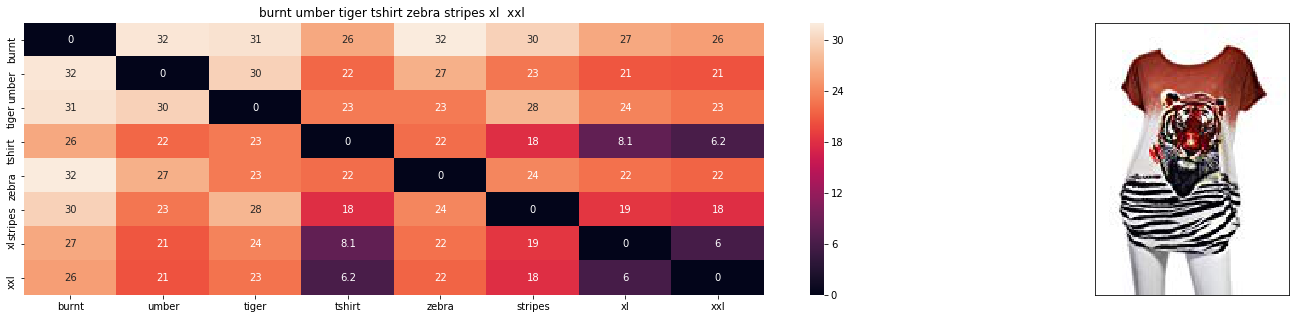

ASIN : B00JXQB5FQ
Brand : Si Row
cosine distance from input : 6.34413156928661e-17


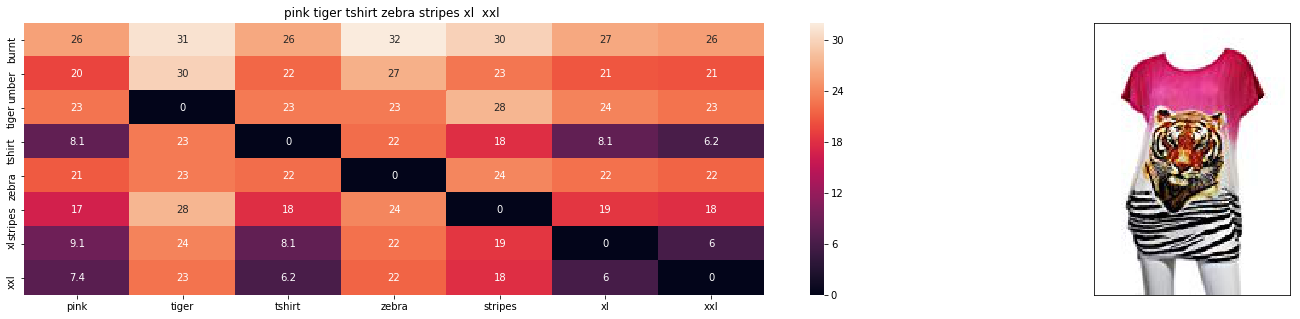

ASIN : B00JXQASS6
Brand : Si Row
cosine distance from input : 0.21213160805660572


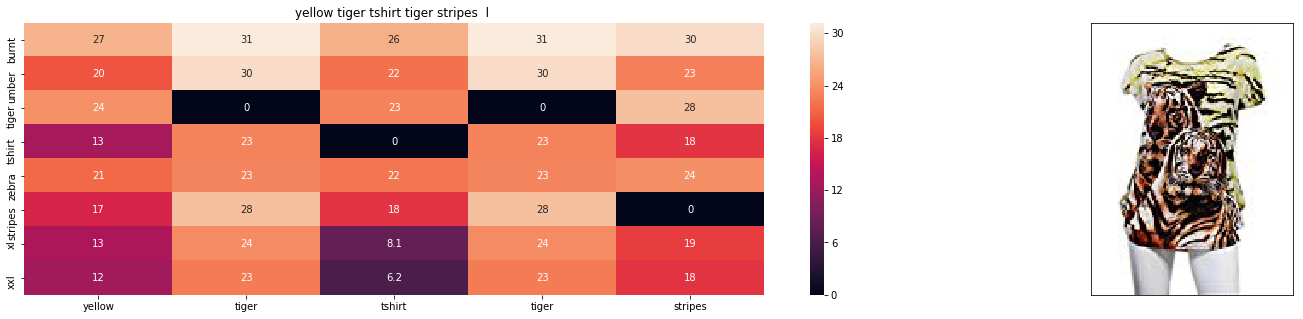

ASIN : B00JXQCUIC
Brand : Si Row
cosine distance from input : 0.3151223283911876


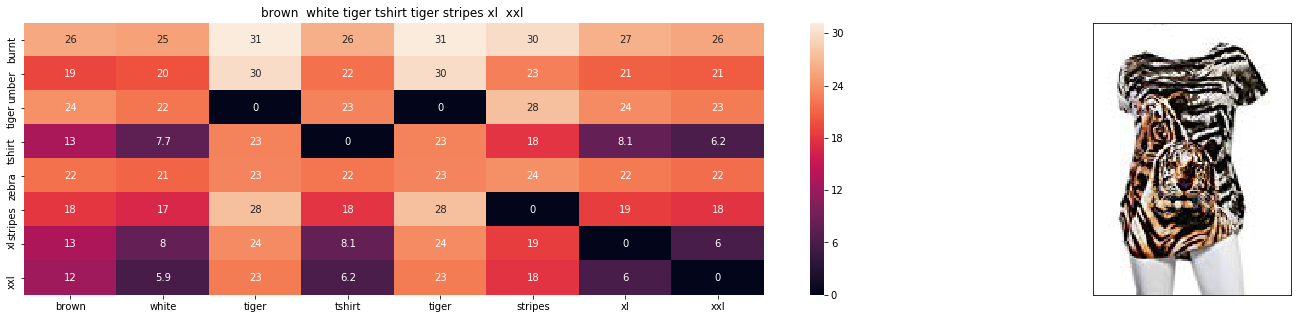

ASIN : B00JXQCWTO
Brand : Si Row
cosine distance from input : 0.32696249229567403


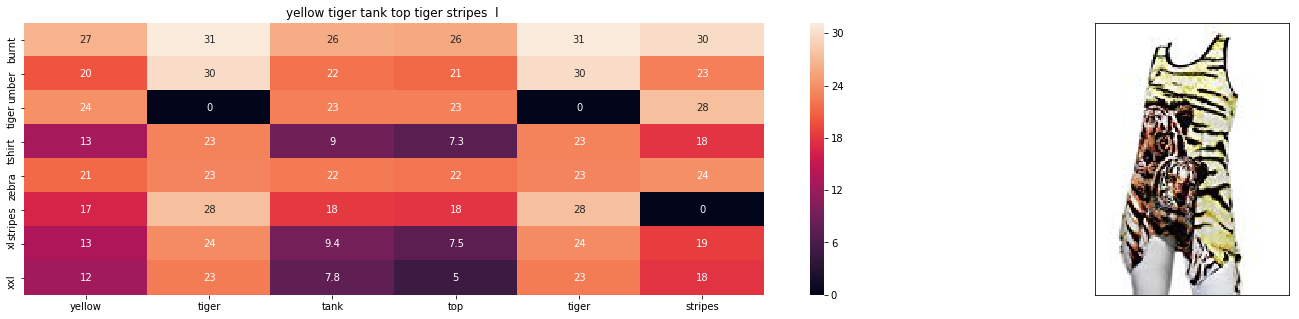

ASIN : B00JXQAUWA
Brand : Si Row
cosine distance from input : 0.42439184094235904


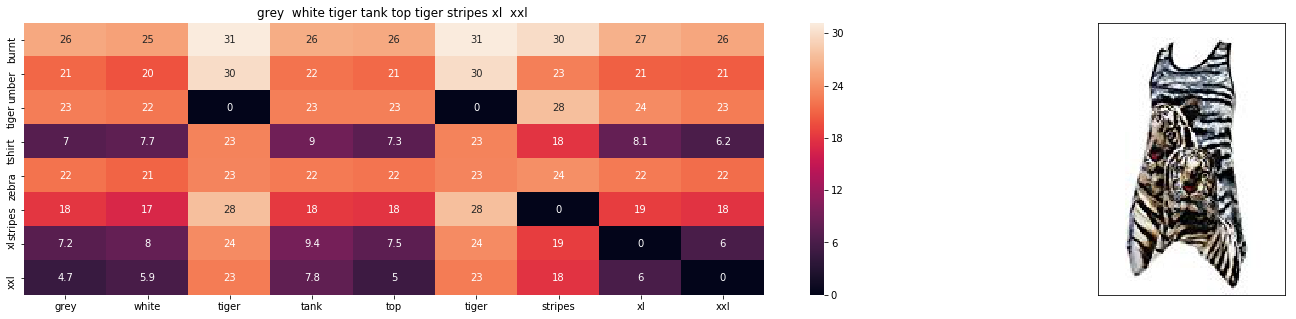

ASIN : B00JXQAFZ2
Brand : Si Row
cosine distance from input : 0.4310336758745186


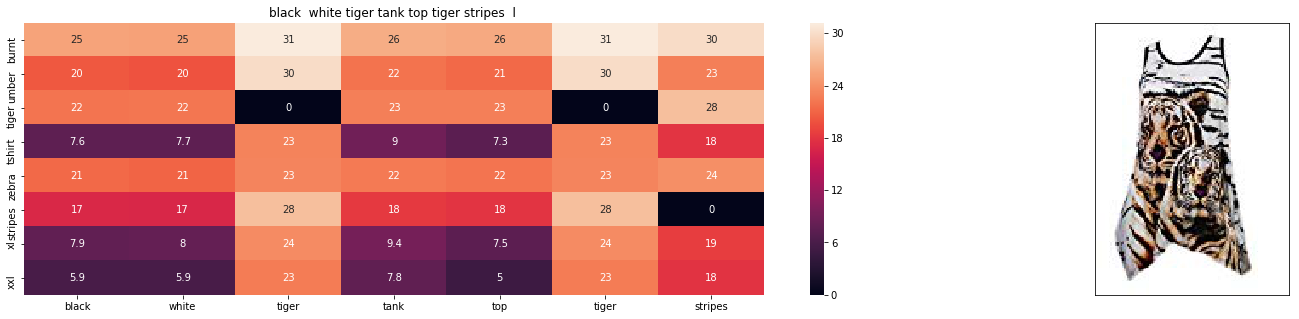

ASIN : B00JXQAO94
Brand : Si Row
cosine distance from input : 0.4346767034419403


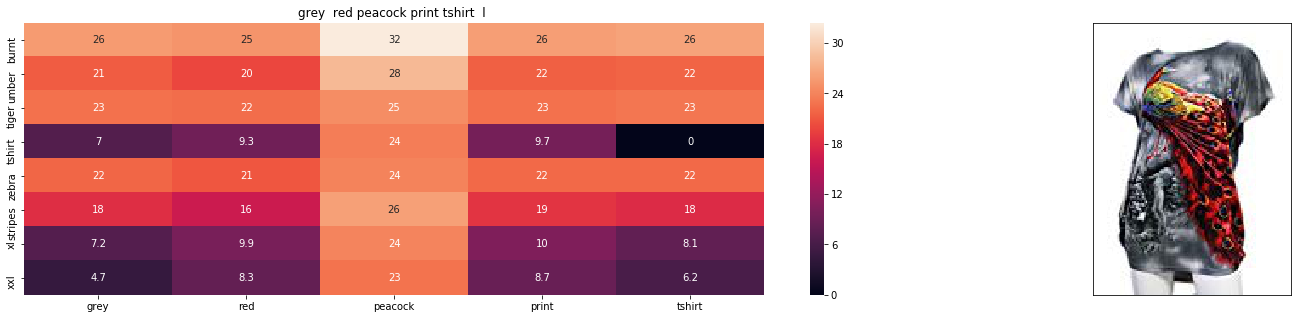

ASIN : B00JXQCFRS
Brand : Si Row
cosine distance from input : 0.530603937455122


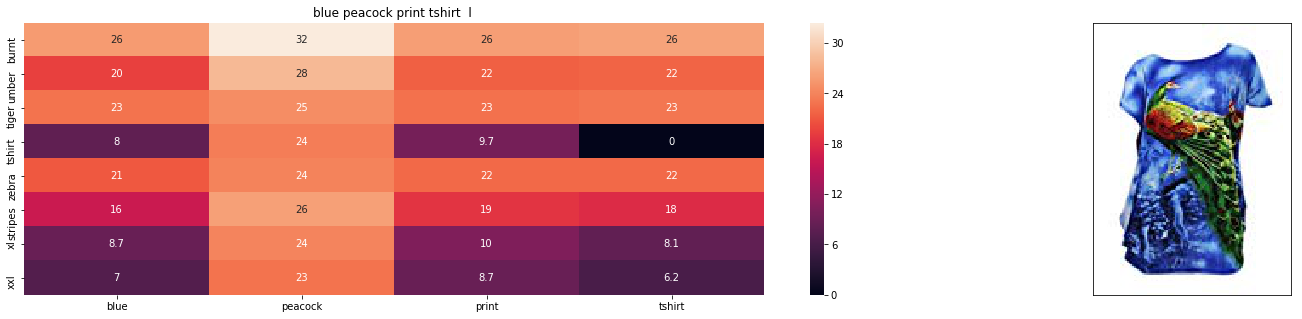

ASIN : B00JXQC8L6
Brand : Si Row
cosine distance from input : 0.5690180969833317


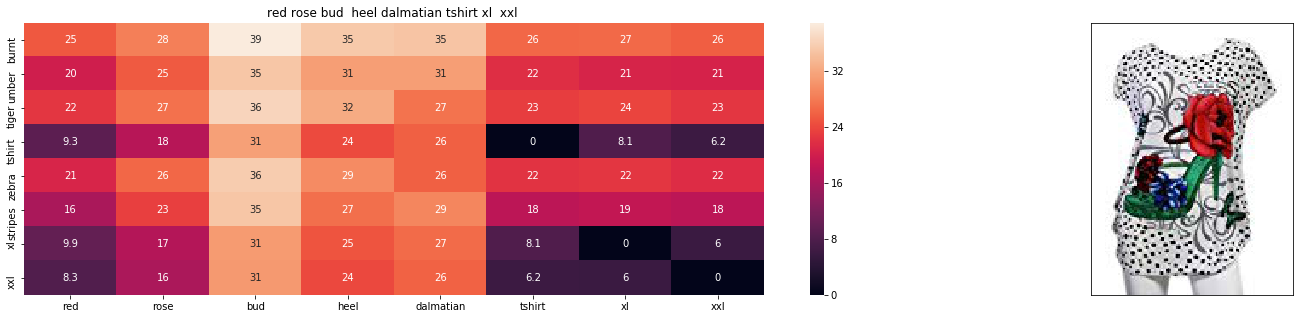

ASIN : B00JXQABB0
Brand : Si Row
cosine distance from input : 0.5762382050801448


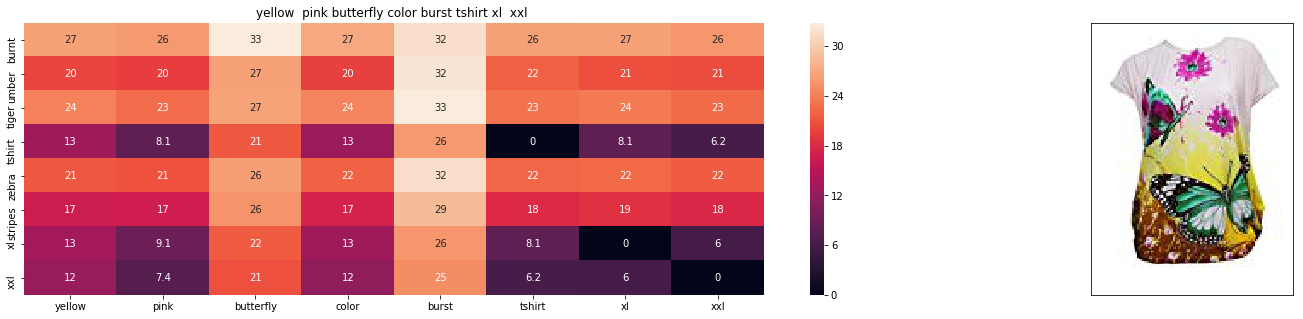

ASIN : B00JXQBBMI
Brand : Si Row
cosine distance from input : 0.5782212537432841


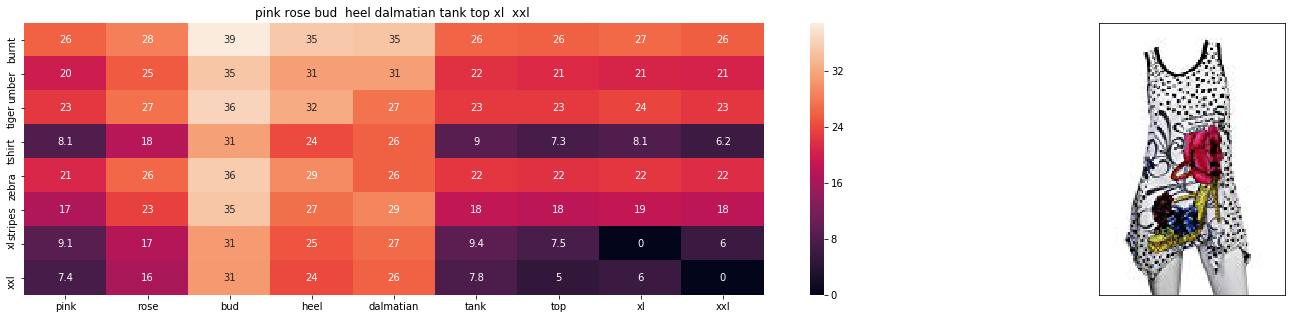

ASIN : B00JXQAX2C
Brand : Si Row
cosine distance from input : 0.5886677304468079


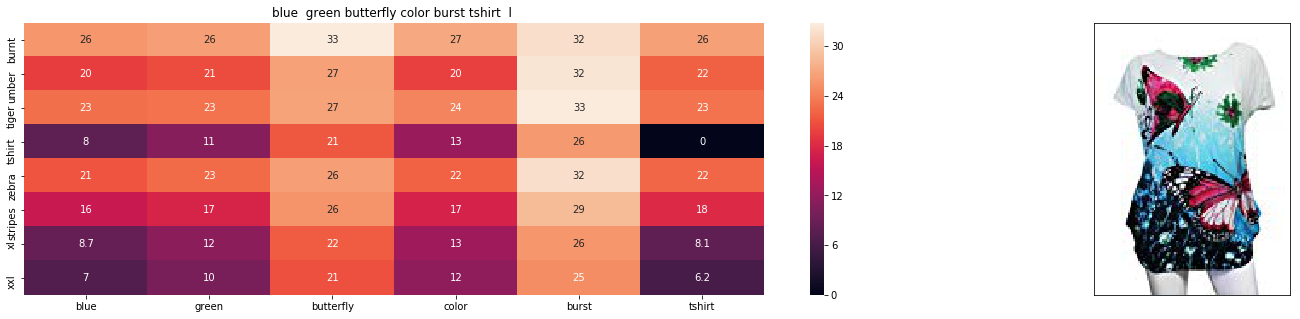

ASIN : B00JXQC0C8
Brand : Si Row
cosine distance from input : 0.6042905504957959


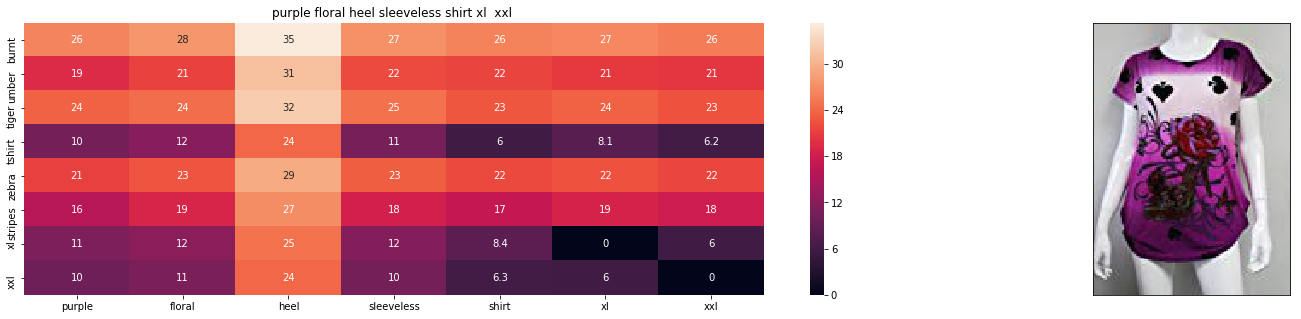

ASIN : B00JV63VC8
Brand : Si Row
cosine distance from input : 0.6188249654693769


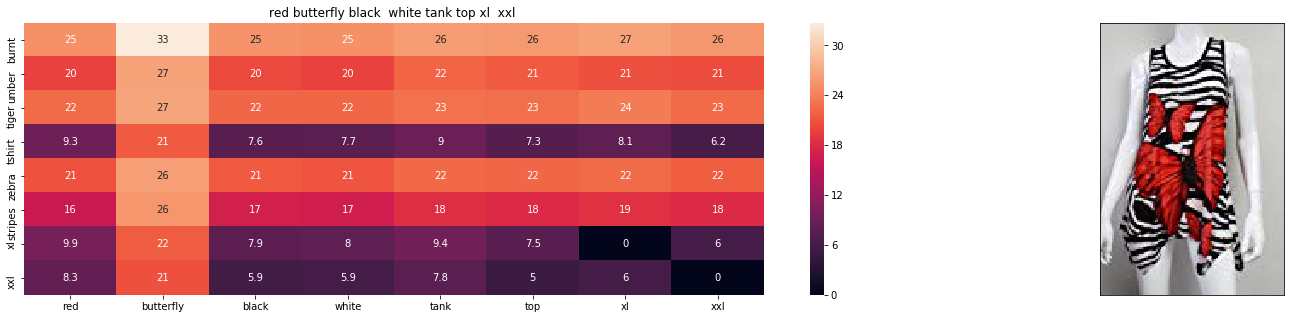

ASIN : B00JV63CW2
Brand : Si Row
cosine distance from input : 0.6190220785019501


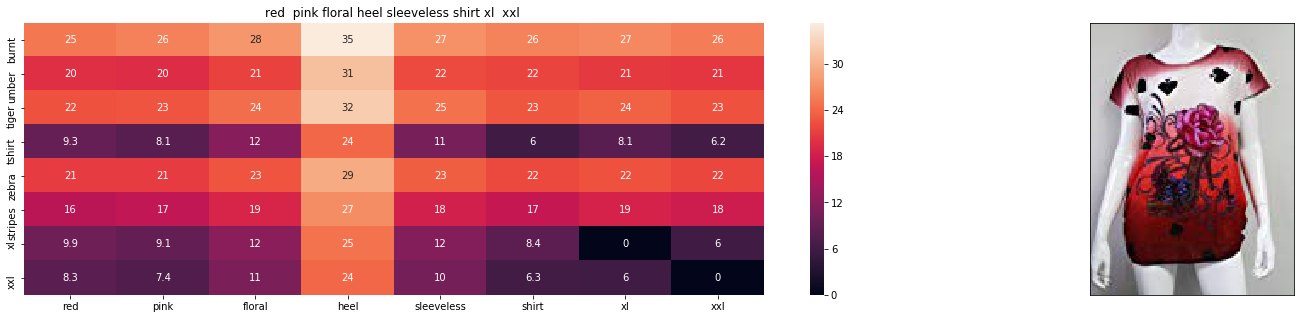

ASIN : B00JV63QQE
Brand : Si Row
cosine distance from input : 0.6239645169340986


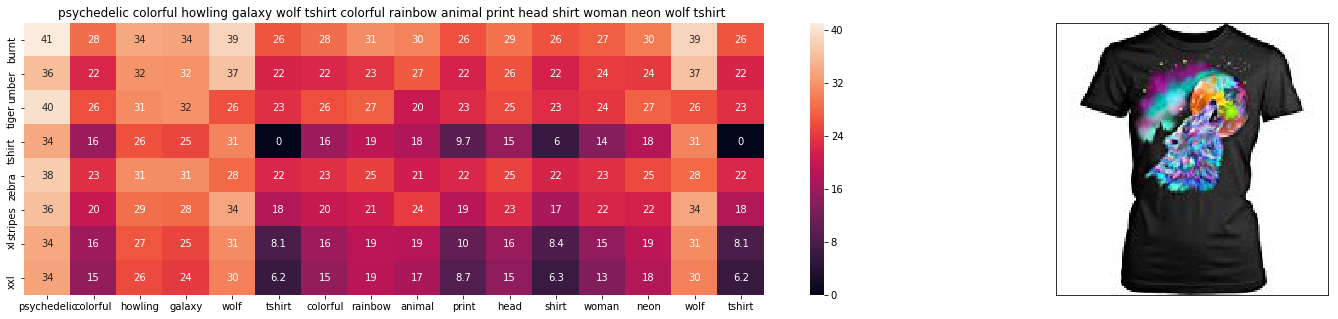

ASIN : B01N37BMUS
Brand : Starchild's Designs
cosine distance from input : 0.811917415687016


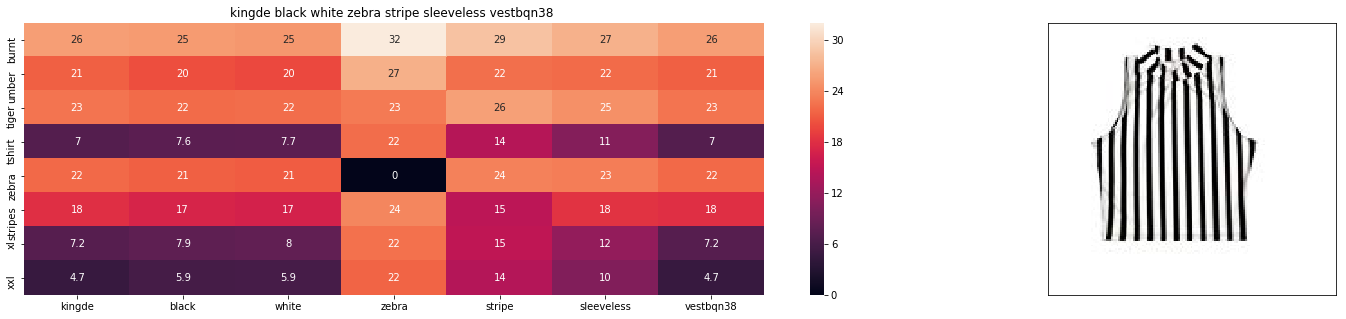

ASIN : B015H41F6G
Brand : KINGDE
cosine distance from input : 0.8125900328159332


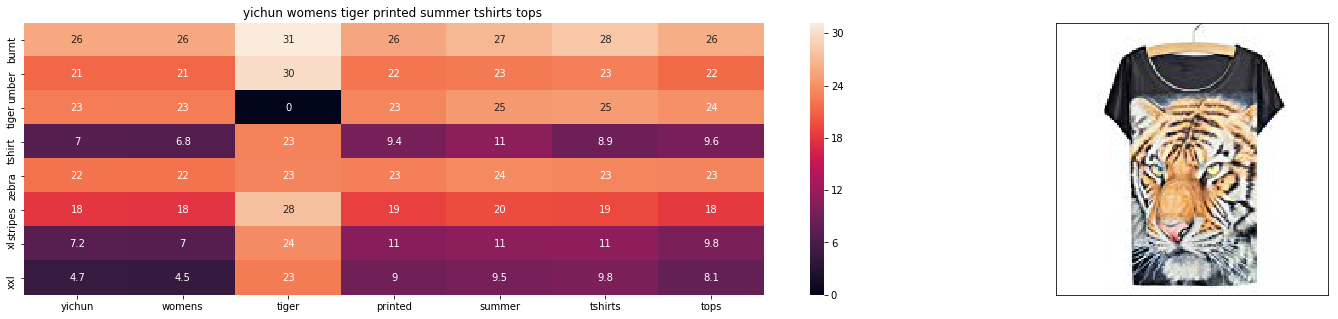

ASIN : B010NN9RXO
Brand : YICHUN
cosine distance from input : 0.8207738782678331


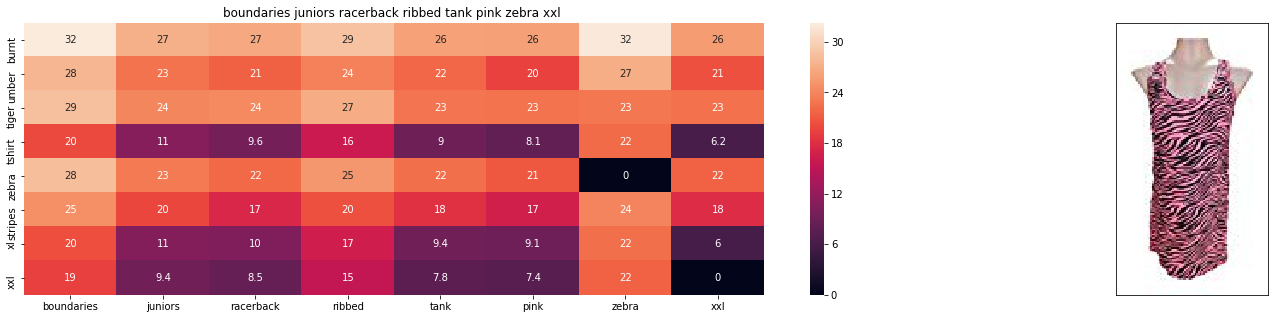

ASIN : B06Y2GTYPM
Brand : No Boundaries
cosine distance from input : 0.8245816145624433


In [21]:
def idf_w2v_final(doc_id, w1, w2, w3,num_results):
    
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1),metric ='cosine')
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id], metric ='cosine')
    img_dist = pairwise_distances(imageFeatures,imageFeatures[doc_id].reshape(1,-1),metric ='cosine')
    
    pairwise_dist   = ((w1 * idf_w2v_dist) +  (w2 * ex_feat_dist) + (w3 * img_dist))/float(w1 + w2 + w3)

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    
 
    df_indices = list(data.index[indices])
        
    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('cosine distance from input :', pdists[i])
        print('='*125)


idf_w2v_final(12566,1,0.8,1,20)
# in the give heat map, each cell contains the euclidean distance between words i, j

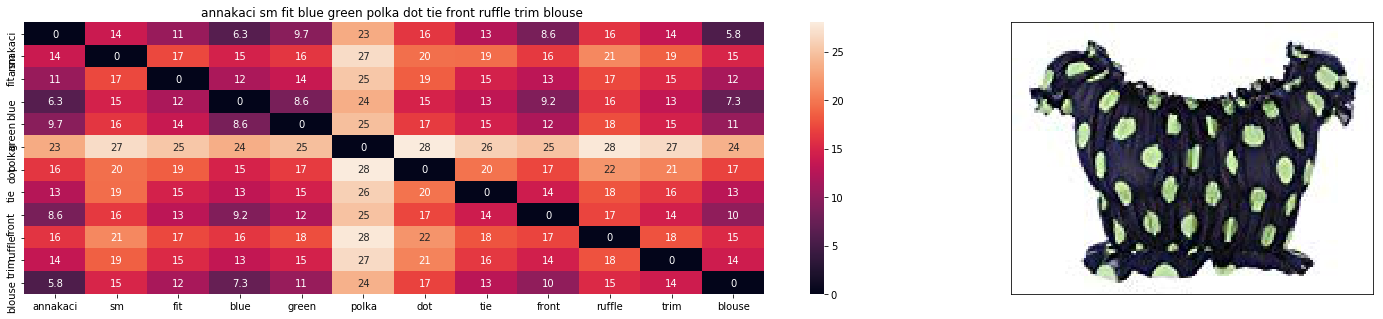

ASIN : B00KLHUIBS
Brand : Anna-Kaci
cosine distance from input : 1.9868214962137642e-08


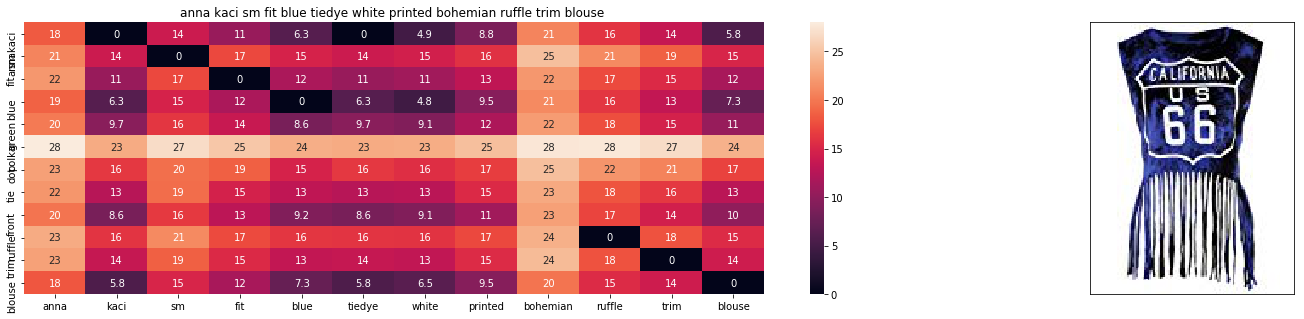

ASIN : B00YQ8S4K0
Brand : Anna-Kaci
cosine distance from input : 0.49526358605572623


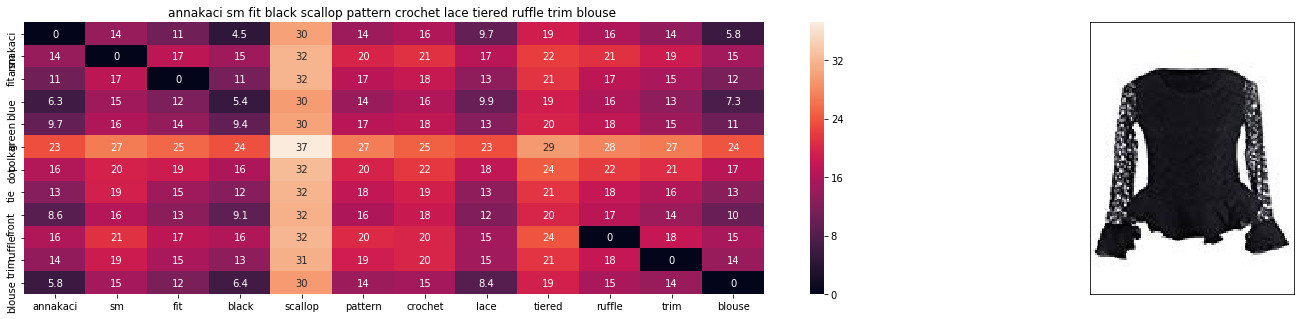

ASIN : B00O194W8W
Brand : Anna-Kaci
cosine distance from input : 0.5509007517323323


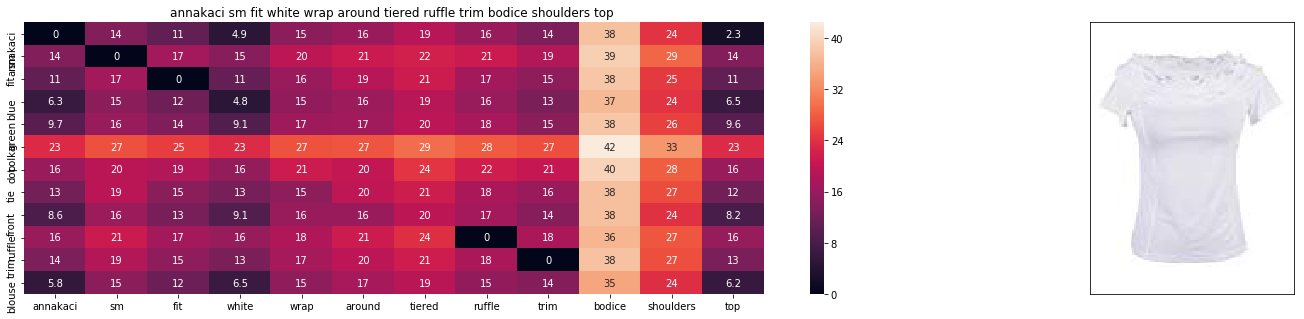

ASIN : B00LMKGFS8
Brand : Anna-Kaci
cosine distance from input : 0.5540532200145715


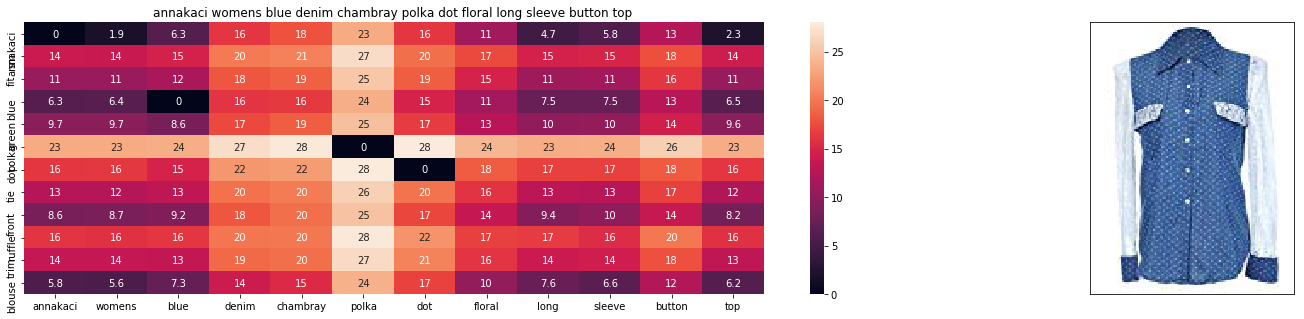

ASIN : B008SMIFN6
Brand : Anna-Kaci
cosine distance from input : 0.5555369154726371


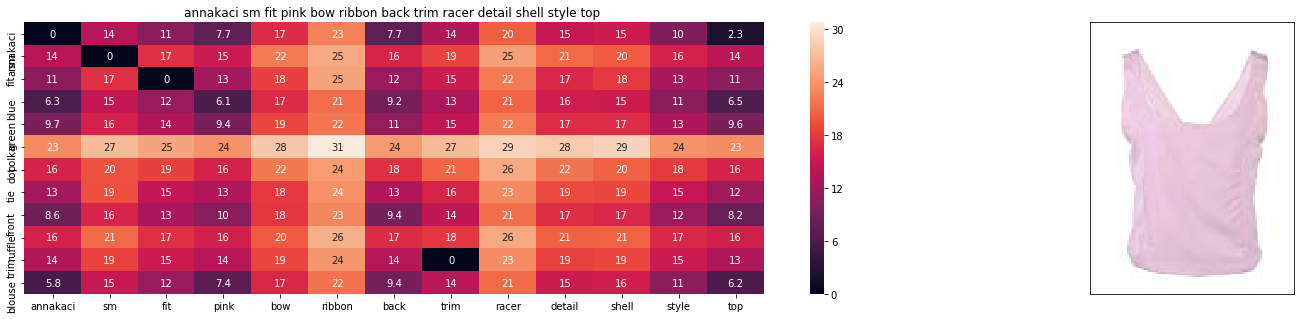

ASIN : B00KOBQEBO
Brand : Anna-Kaci
cosine distance from input : 0.5581961464445789


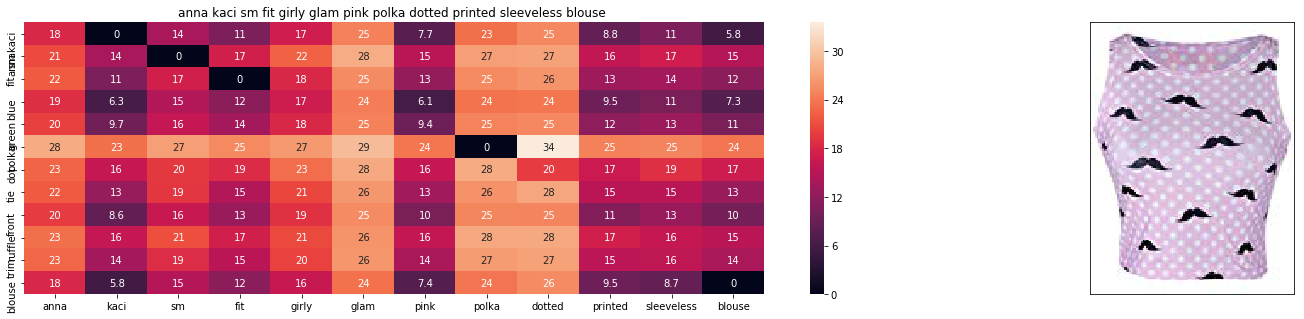

ASIN : B010EH3PRS
Brand : Anna-Kaci
cosine distance from input : 0.5616210094651579


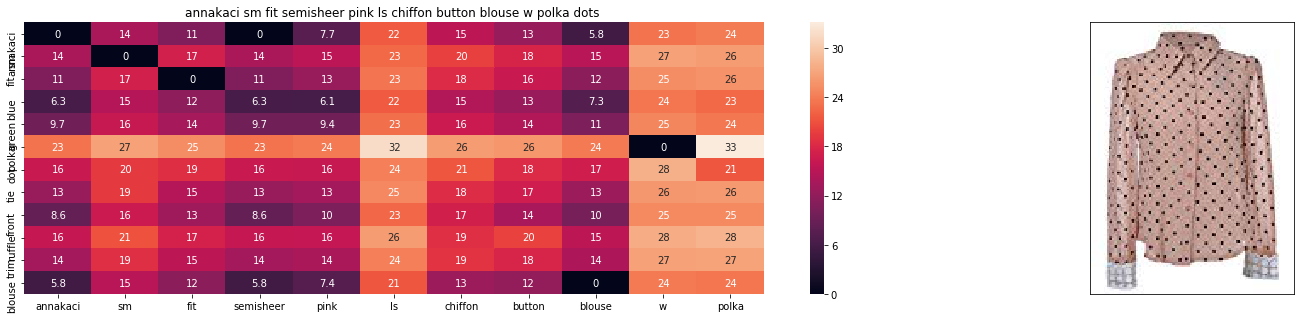

ASIN : B008Z5ST3C
Brand : Anna-Kaci
cosine distance from input : 0.5736202589234709


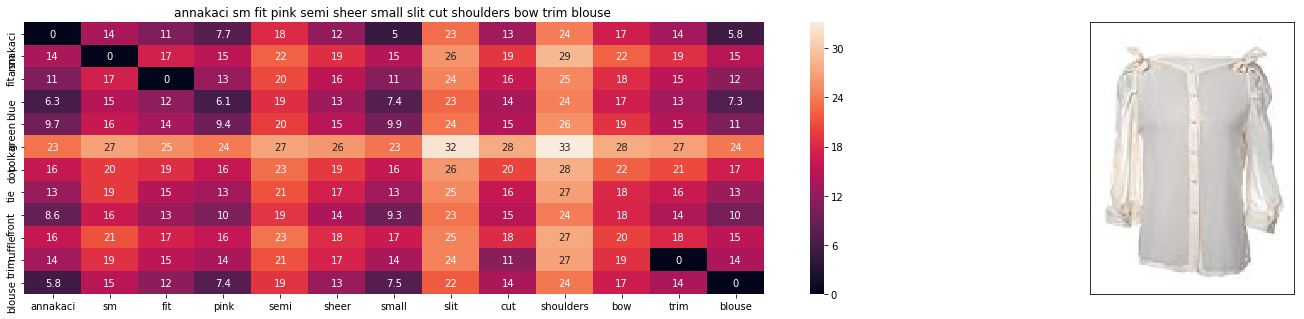

ASIN : B00HM9OD8W
Brand : Anna-Kaci
cosine distance from input : 0.5778862626911202


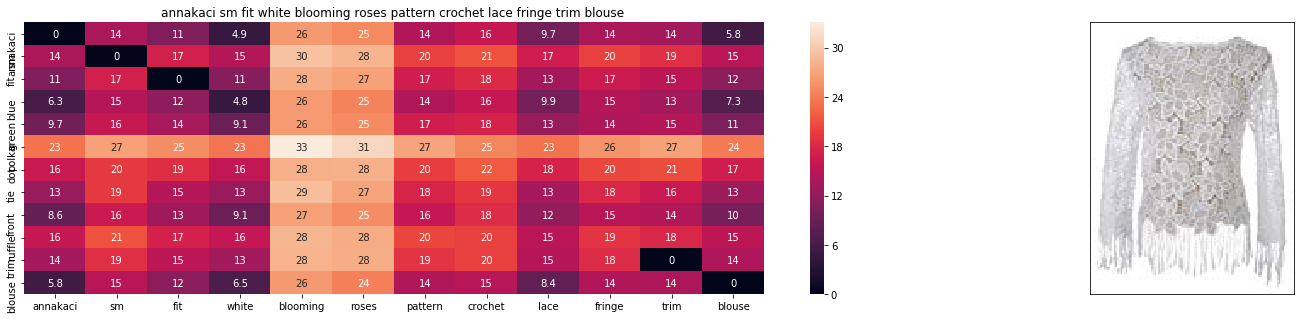

ASIN : B00RDLAR2A
Brand : Anna-Kaci
cosine distance from input : 0.5798220364856713


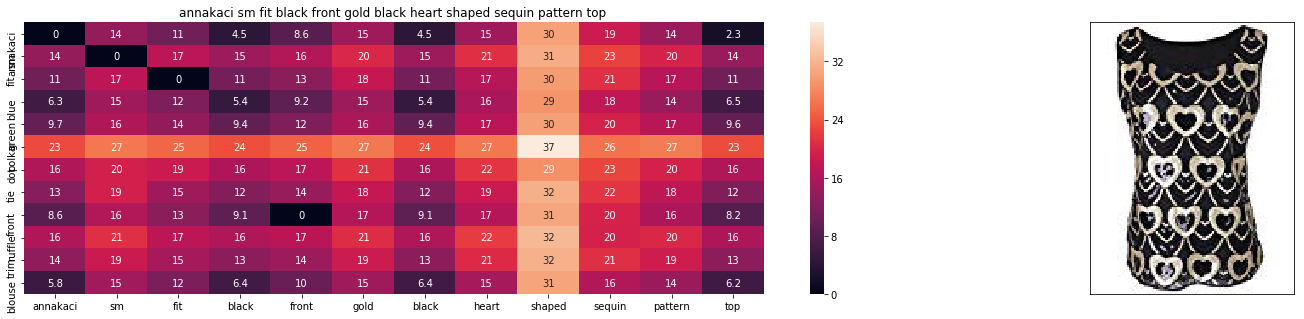

ASIN : B00SIALRLA
Brand : Anna-Kaci
cosine distance from input : 0.5801352206692525


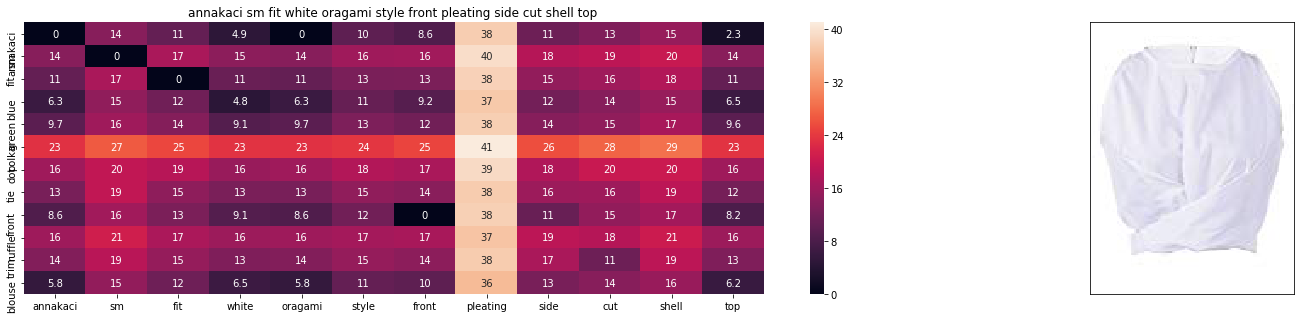

ASIN : B00LU4Z2YY
Brand : Anna-Kaci
cosine distance from input : 0.5817045101133975


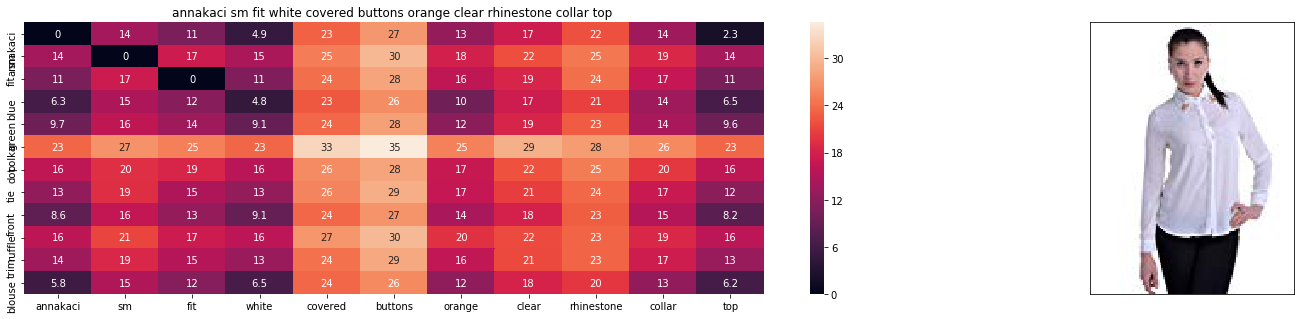

ASIN : B00B62BXES
Brand : Anna-Kaci
cosine distance from input : 0.5827084907499942


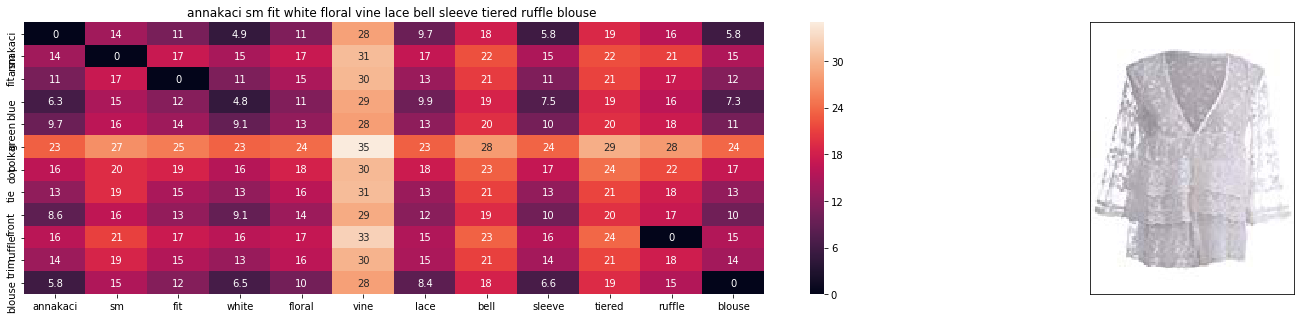

ASIN : B00DVOAWM8
Brand : Anna-Kaci
cosine distance from input : 0.584937644859949


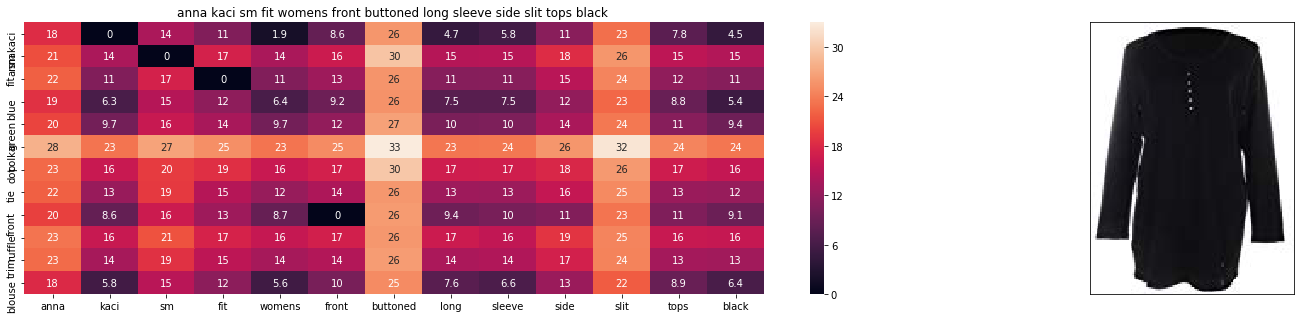

ASIN : B019820A4Q
Brand : Anna-Kaci
cosine distance from input : 0.5875102821812459


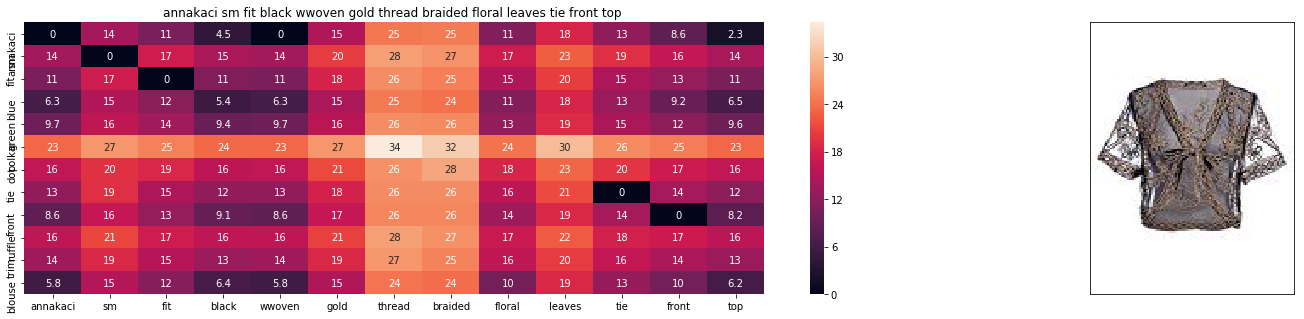

ASIN : B00E7Z8DWQ
Brand : Anna-Kaci
cosine distance from input : 0.5887115939284789


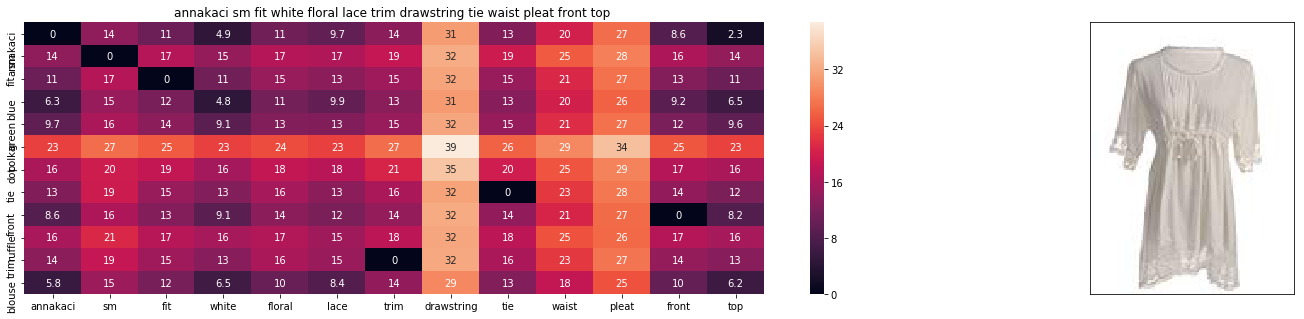

ASIN : B00DW1NKSS
Brand : Anna-Kaci
cosine distance from input : 0.5925832121181481


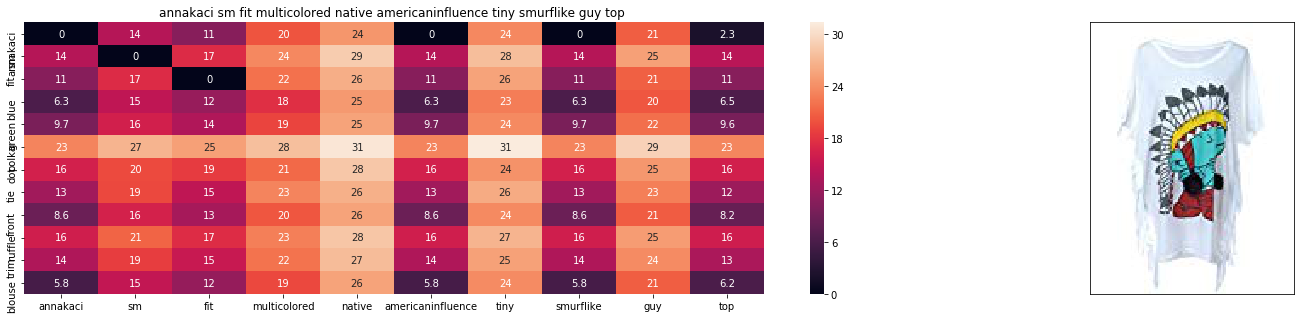

ASIN : B008696WQS
Brand : Anna-Kaci
cosine distance from input : 0.5967419473934167


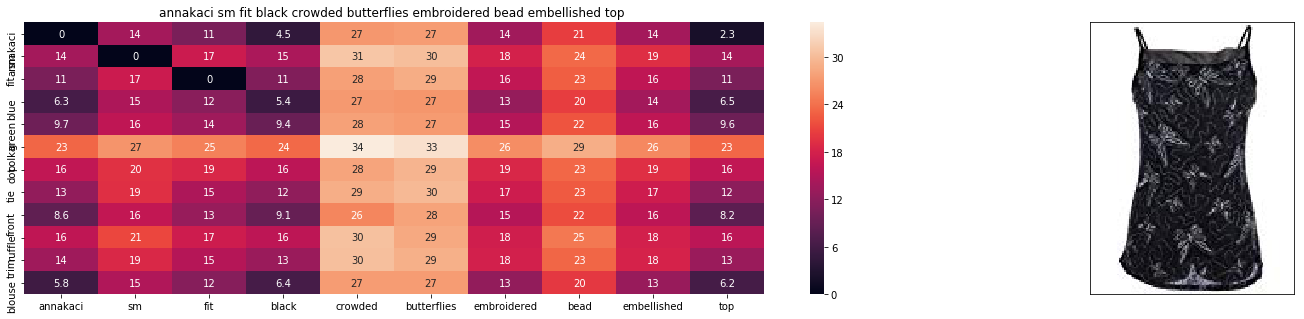

ASIN : B00PGFZ96O
Brand : Anna-Kaci
cosine distance from input : 0.6001286649530558


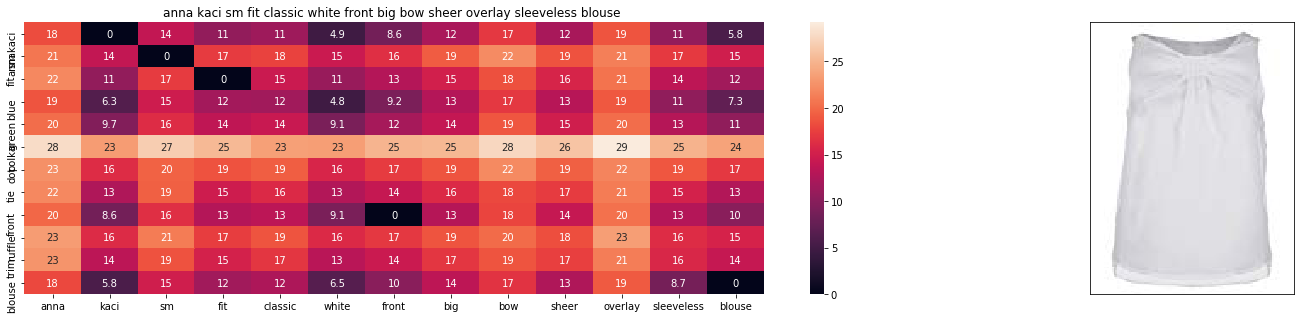

ASIN : B010EH3S02
Brand : Anna-Kaci
cosine distance from input : 0.6003026891358686


In [50]:
idf_w2v_final(931,1,1,1,20)
# in the give heat map, each cell contains the euclidean distance between words i, j

# Weighted similarity using Text, Visual,Brand and Color.

__ Representation types __

* Title's text are represented with __Word vectors calculated using Truncated SVD__. 

* Image vectors are represented using Convolutional neural networks.

* Brand and Color are represented using One Hot Encoding.

In [26]:
data.head(1)

asin        brand              color  \
4  B004GSI2OS  FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  \
4  featherlite ladies long sleeve stain resistant...          $26.26   

                                      image_features  
4  [0.1865767, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

## Stemming the titles

In [23]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

cleaned_titles =[]

for row in data['title'].values:
    cleaned_title =[]
    for word in row.split():
        cleaned_word = stemmer.stem(word)
        cleaned_title.append(cleaned_word)
    cleaned_title = " ".join(cleaned_title)
    cleaned_titles.append(cleaned_title)

cleaned_title_df = pd.DataFrame(cleaned_titles,columns=['cleaned_title'])

## Calculating Word vectors using Truncated SVD

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_instance = TfidfVectorizer()
tfidf_vec = tfidf_instance.fit_transform(cleaned_title_df['cleaned_title'])
tfidf_vec

<16042x11498 sparse matrix of type '<class 'numpy.float64'>'
	with 147198 stored elements in Compressed Sparse Row format>

In [5]:
important_words_list = tfidf_instance.get_feature_names()

In [26]:
titles = list(cleaned_title_df['cleaned_title'])

In [27]:
for i in range(0,len(titles)):
    titles[i] = titles[i].split()


tf_idf ={}
count = 1
for imp_word in important_words_list:
    tf_idf.update({imp_word : count})
    count = count +1

import numpy as np
co_occurance_matrix = np.random.normal(loc=0,scale=0,size=tuple([len(important_words_list),len(important_words_list)]))

In [29]:
from tqdm import tqdm

for i in tqdm(range(0,len(titles))):
    for j in range(0,len(titles[i])):
        word = titles[i][j]
        if tf_idf.get(word) :
            value_i = tf_idf.get(word) - 1
            j=j+1
            if j < len(titles[i]):
                word2 = titles[i][j] 
                if tf_idf.get(word2):
                    value_j = tf_idf.get(word2) - 1
                    co_occurance_matrix[value_i][value_j] = co_occurance_matrix[value_i][value_j] + 1 
            j=j+1
            if j < len(titles[i]):
                word2 = titles[i][j] 
                if tf_idf.get(word2):
                    value_j = tf_idf.get(word2) - 1
                    co_occurance_matrix[value_i][value_j] = co_occurance_matrix[value_i][value_j] + 1
            j=j+1
            if j < len(titles[i]):
                word2 = titles[i][j]
                if tf_idf.get(word2):
                    value_j = tf_idf.get(word2) - 1
                    co_occurance_matrix[value_i][value_j] = co_occurance_matrix[value_i][value_j] + 1
            j=j+1
            if j < len(titles[i]):
                word2 = titles[i][j]
                if tf_idf.get(word2):
                    value_j = tf_idf.get(word2) - 1
                    co_occurance_matrix[value_i][value_j] = co_occurance_matrix[value_i][value_j] + 1
            j=j+1
            if j < len(titles[i]):
                word2 = titles[i][j]
                if tf_idf.get(word2):
                    value_j = tf_idf.get(word2) - 1
                    co_occurance_matrix[value_i][value_j] = co_occurance_matrix[value_i][value_j] + 1
            j=j-6 
            if j > -1:
                word2 = titles[i][j]
                if tf_idf.get(word2):
                    value_j = tf_idf.get(word2) - 1
                    co_occurance_matrix[value_i][value_j] = co_occurance_matrix[value_i][value_j] + 1
            j=j-1
            if j > -1:
                word2 = titles[i][j]
                if tf_idf.get(word2):
                    value_j = tf_idf.get(word2) - 1
                    co_occurance_matrix[value_i][value_j] = co_occurance_matrix[value_i][value_j] + 1
            j=j-1
            if j > -1:
                word2 = titles[i][j]
                if tf_idf.get(word2):
                    value_j = tf_idf.get(word2) - 1
            
                    co_occurance_matrix[value_i][value_j] = co_occurance_matrix[value_i][value_j] + 1
            j=j-1
            if j > -1:
                word2 = titles[i][j] 
                if tf_idf.get(word2):
                    value_j = tf_idf.get(word2) - 1
                    co_occurance_matrix[value_i][value_j] = co_occurance_matrix[value_i][value_j] + 1
            j=j-1
            if j > -1:
                word2 = titles[i][j]
                if tf_idf.get(word2):
                    value_j = tf_idf.get(word2) - 1
                    co_occurance_matrix[value_i][value_j] = co_occurance_matrix[value_i][value_j] + 1

                   

100%|██████████| 16042/16042 [00:03<00:00, 4446.82it/s]


In [30]:
print("Is the co-occurance matrix symmentric ? ",np.allclose(co_occurance_matrix, co_occurance_matrix.T))

Is the co-occurance matrix symmentric ?  True


100%|██████████| 11/11 [10:33<00:00, 88.82s/it]


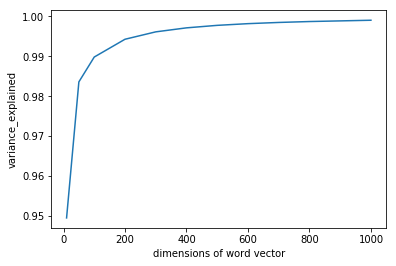

In [488]:
from sklearn.decomposition import TruncatedSVD
dimensions = [10,50,100,200,300,400,500,600,700,800,1000]
var_explained =[]
for d in tqdm(dimensions):
    svd = TruncatedSVD(n_components=d)
    word_vector = svd.fit_transform(co_occurance_matrix)
    variance = svd.explained_variance_ratio_.sum()
    var_explained.append(variance)
plt.plot(dimensions,var_explained)
plt.xlabel('dimensions of word vector')
plt.ylabel('variance_explained')
plt.show()

In [32]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300)
word_vector = svd.fit_transform(co_occurance_matrix)
variance = svd.explained_variance_ratio_.sum()
print("percentage of information regained after dimensinality reduction ",variance*100)

percentage of information regained after dimensinality reduction  99.74639398712985


In [33]:
import pickle as pk

## saving variables to pickle
with open('amazon_apparel_objs.pkl', 'wb') as f:
    pk.dump([word_vector,data,cleaned_title_df],f)


## Featurizing the title's text with word vectors

In [27]:
import pickle as pk

with open('amazon_apparel_objs.pkl', 'rb') as f:
    word_vector,data,cleaned_title_df= pk.load(f)



In [29]:
def build_word_vector_svd(sentance):
    featureVec = np.zeros((300,), dtype="float32")
    for word in sentance.split():
        try:
            ind = important_words_list.index(word)
            featureVec = np.add(featureVec,word_vector[ind])
        except ValueError:
            featureVec = featureVec
    featureVec = featureVec/len(sentance.split())
    return featureVec
        

In [30]:
cleaned_title_df.index = data.index

In [31]:
from tqdm import tqdm

sentence_vector_svd =[]
for i in tqdm(range(0,cleaned_title_df.shape[0])):
    sentence_vector_svd.append(build_word_vector_svd(cleaned_title_df['cleaned_title'].iloc[i]))

sentence_vector_svd = scale(sentence_vector_svd)

svd_df = pd.DataFrame([[i] for i in sentence_vector_svd],columns =['svd_features'])
svd_df.index = cleaned_title_df.index


100%|██████████| 16042/16042 [00:28<00:00, 566.04it/s]


In [34]:
cleaned_title_df = pd.concat([cleaned_title_df,svd_df],axis =1)

In [37]:
data = pd.concat([data,cleaned_title_df],axis =1)
data.head(1)

asin        brand              color  \
4  B004GSI2OS  FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  \
4  featherlite ladies long sleeve stain resistant...          $26.26   

                                      image_features  \
4  [0.1865767, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                       cleaned_title  \
4  featherlit ladi long sleev stain resist taper ...   

                                        svd_features  
4  [-0.6961520981475411, -0.47727537705842377, -1...

## Results:

Actual Product Title burnt umber tiger tshirt zebra stripes xl  xxl 
ASIN : B00JXQB5FQ
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 7.401486830834377e-17


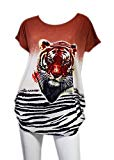

Recommended Product Title pink tiger tshirt zebra stripes xl  xxl 
ASIN : B00JXQASS6
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.16176779903025207


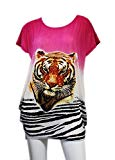

Recommended Product Title brown  white tiger tshirt tiger stripes xl  xxl 
ASIN : B00JXQCWTO
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.26434921903674496


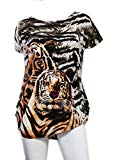

Recommended Product Title yellow tiger tshirt tiger stripes  l 
ASIN : B00JXQCUIC
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.325282183277017


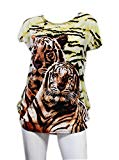

Recommended Product Title grey  white tiger tank top tiger stripes xl  xxl 
ASIN : B00JXQAFZ2
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.36919620593592795


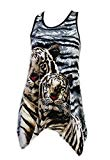

Recommended Product Title yellow  pink butterfly color burst tshirt xl  xxl 
ASIN : B00JXQBBMI
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.45035167011682803


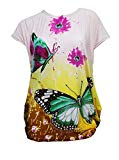

Recommended Product Title yellow tiger tank top tiger stripes  l 
ASIN : B00JXQAUWA
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.4525811108522726


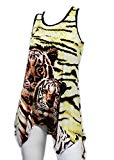

Recommended Product Title red rose bud  heel dalmatian tshirt xl  xxl 
ASIN : B00JXQABB0
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.4541551660454772


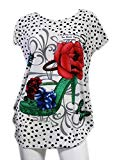

Recommended Product Title purple floral heel sleeveless shirt xl  xxl 
ASIN : B00JV63VC8
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.4568234442908167


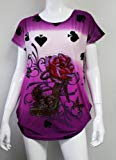

Recommended Product Title black  white tiger tank top tiger stripes  l 
ASIN : B00JXQAO94
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.4629079925516635


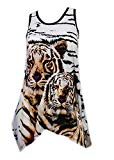

Recommended Product Title pink rose bud  heel dalmatian tank top xl  xxl 
ASIN : B00JXQAX2C
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.47232855600728946


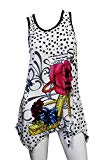

Recommended Product Title red  pink floral heel sleeveless shirt xl  xxl 
ASIN : B00JV63QQE
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.47883555143809686


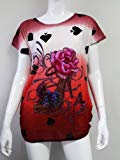

Recommended Product Title red butterfly black  white tank top xl  xxl 
ASIN : B00JV63CW2
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.4880779262052996


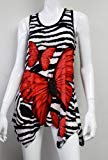

Recommended Product Title blue  green butterfly color burst tshirt  l 
ASIN : B00JXQC0C8
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.5814166952020138


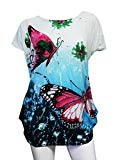

Recommended Product Title grey  red peacock print tshirt  l 
ASIN : B00JXQCFRS
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.5957164086894106


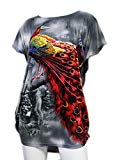

Recommended Product Title blue peacock print tshirt  l 
ASIN : B00JXQC8L6
Brand : Si Row
Product Type: TOYS_AND_GAMES
cosine distance from input : 0.6145142785508041


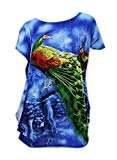

Recommended Product Title antthony maxine striped crossover top xl 
ASIN : B01M73YDQQ
Brand : Antthony
Product Type: SHIRT
cosine distance from input : 0.7753178796187695


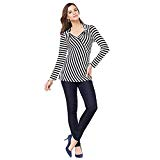

Recommended Product Title stylus coldshoulder striped top size xl 
ASIN : B01MTF5OG7
Brand : Stylus
Product Type: ACCESSORY
cosine distance from input : 0.7850317560703394


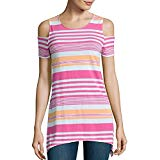

Recommended Product Title genuine mother road historic route 66 road trip tshirt xxl 
ASIN : B007O0X8JE
Brand : Gravity
Product Type: APPAREL
cosine distance from input : 0.7861019214273086


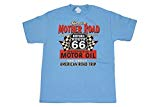

Recommended Product Title leoy88 women floral striped splicing tshirt long sleeve blouse xl 
ASIN : B01MCTEKO7
Brand : Leoy88 Women Blouse
Product Type: SHIRT
cosine distance from input : 0.7870695981469553


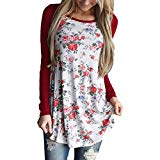

In [52]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo

from sklearn.preprocessing import scale

def idf_w2v_final_svd(doc_id, w1, w2, w3,num_results):
    
    idf_w2v_dist  = pairwise_distances(sentence_vector_svd, sentence_vector_svd[doc_id].reshape(1,-1),metric ='cosine')
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id],metric='cosine')
    img_dist = pairwise_distances(imageFeatures,imageFeatures[doc_id].reshape(1,-1),metric ='cosine')
    
    pairwise_dist   = ((w1*idf_w2v_dist) +  (w2*ex_feat_dist)+ ( w3*img_dist))/float(w1 + w2 + w3)

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    
 
    df_indices = list(data.index[indices])
        
    for i in range(0, len(indices)):
        if i == 0:
            print("Actual Product Title",data['title'].loc[df_indices[i]])  
        else:
            print("Recommended Product Title",data['title'].loc[df_indices[i]]) 
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('Product Type:',data['product_type_name'].loc[df_indices[i]])
        print('cosine distance from input :', pdists[i])
        display(Image(url=data['medium_image_url'].loc[df_indices[i]], embed=True))
        print('='*125)


idf_w2v_final_svd(12566,1,1,1,20)

Actual Product Title annakaci sm fit blue green polka dot tie front ruffle trim blouse 
ASIN : B00KLHUIBS
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 3.700743415417188e-17


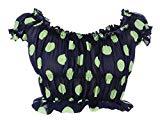

Recommended Product Title annakaci sm fit semisheer pink ls chiffon button blouse w polka dots 
ASIN : B008Z5ST3C
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5183596487357885


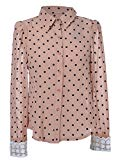

Recommended Product Title annakaci sm fit lime green white exciting sporty tennis cool days blouse top 
ASIN : B007Y9SZSY
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5355386750757204


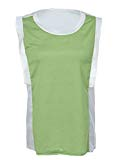

Recommended Product Title annakaci sm fit white floral lace trim drawstring tie waist pleat front top 
ASIN : B00DW1NKSS
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.545715642462827


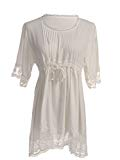

Recommended Product Title anna kaci sm fit girly glam pink polka dotted printed sleeveless blouse 
ASIN : B010EH3PRS
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5545606742683089


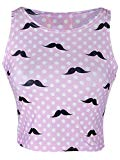

Recommended Product Title annakaci sm fit white wrap around tiered ruffle trim bodice shoulders top 
ASIN : B00LMKGFS8
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5557342585888533


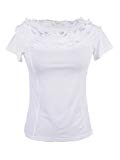

Recommended Product Title annakaci womens blue denim chambray polka dot floral long sleeve button top 
ASIN : B008SMIFN6
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5564868716794363


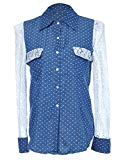

Recommended Product Title anna kaci sm fit blue tiedye white printed bohemian ruffle trim blouse 
ASIN : B00YQ8S4K0
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5569064219054212


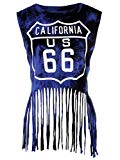

Recommended Product Title annakaci sm fit knife pleat neckline ruffle edge poncho style blouse 
ASIN : B00HCNNOJW
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5664968287605475


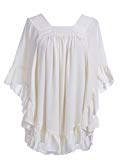

Recommended Product Title annakaci sm fit black scallop pattern crochet lace tiered ruffle trim blouse 
ASIN : B00O194W8W
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5698907589181758


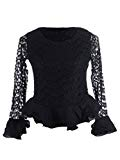

Recommended Product Title annakaci sm fit black wwoven gold thread braided floral leaves tie front top 
ASIN : B00E7Z8DWQ
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5773727321605492


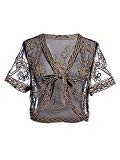

Recommended Product Title annakaci sm fit pink bow ribbon back trim racer detail shell style top 
ASIN : B00KOBQEBO
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5812780737521939


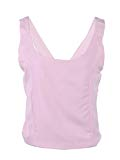

Recommended Product Title annakaci sm fit multicolored native americaninfluence tiny smurflike guy top 
ASIN : B008696WQS
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5823057416070149


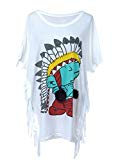

Recommended Product Title annakaci sm fit black grey ruffle sheer panel trim elastic cuffs top 
ASIN : B00OIBU11K
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5870834028011753


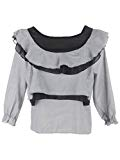

Recommended Product Title annakaci sm fit white oragami style front pleating side cut shell top 
ASIN : B00LU4Z2YY
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5894551170279354


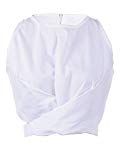

Recommended Product Title annakaci sm fit black front gold black heart shaped sequin pattern top 
ASIN : B00SIALRLA
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5933956115725477


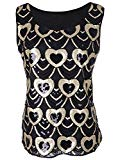

Recommended Product Title annakaci sm fit blue cord ruffle trim tiered hem drop waist denim blouse 
ASIN : B0759G15ZX
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.595253727171518


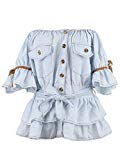

Recommended Product Title annakaci sm fit black vneckline exposed golden zipper back crop waist top 
ASIN : B00JJ1U3J4
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.596487329368141


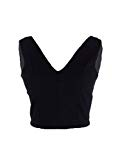

Recommended Product Title annakaci sm fit pink semi sheer small slit cut shoulders bow trim blouse 
ASIN : B00HM9OD8W
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5965369475704532


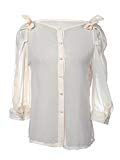

Recommended Product Title annakaci sm fit pink sheer cord trim panel shoulders bejeweled tip collar top 
ASIN : B00DDZS7EK
Brand : Anna-Kaci
Product Type: SHIRT
cosine distance from input : 0.5993682824159364


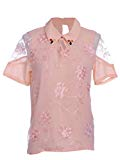

In [53]:
idf_w2v_final_svd(931,1,1,1,20)

# Procedure

* It was clear that the main objective for this bussiness problem was to recommend the similar products using Visual, Text, Brand and Color.

* Cleaned data and  analysed it.

* Limited the number of data points by removing the data points with no price.

* Assumed the closest data points as duplicates and removed them.

* Pre-processed the text data.

* Vectorized the text data using IDF weighted Word to vector representation.

* Vectorized the brands,colors and images 

* Standardized all the features.

* Calculated the weighted similarity using the following feature representations

    - Title's texts were represented with __IDF weighted Word to vector__. 
    - Image vectors were represented using Convolutional neural networks.
    - Brand and Color features were represented using One Hot Encoding.

* visualized the recommended products.

* Vectorized the text data with word vectors (calculated using Truncated SVD).

* Calculated the weighted similarity using the following feature representations

    - Title's texts were represented with __Word vectors calculated using Truncated SVD__. 
    - Image vectors were represented using Convolutional neural networks.
    - Brand and Color features were represented using One Hot Encoding.

* visualized the recommended products.